In [1]:
## For some actions, you may want to require human approval before running to ensure that everything is running as intended.
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [3]:
llm.invoke("hello")

AIMessage(content='Hello! 👋\n\nHow can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26, 'completion_time': 0.027272727, 'prompt_time': 0.001905878, 'queue_time': 0.23027233, 'total_time': 0.029178605}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-ec243171-0241-4146-87e7-22097cb367c5-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26})

In [4]:
llm.invoke("hi").content

'Hi! 👋  How can I help you today?\n'

In [5]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [6]:
multiply({"first_number":24,"second_number":364})

C:\Users\divak\AppData\Local\Programs\Python\Python311\ipykernel_6660\2089873997.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":24,"second_number":364})


8736

In [7]:
multiply.invoke({"first_number":24,"second_number":364})

8736

In [8]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [9]:
search("What is Trump Tarrif?")

[{'url': 'https://en.wikipedia.org/wiki/Tariffs_in_the_second_Trump_administration',
  'content': 'On April 2—a day he called "Liberation Day"—Trump signed an executive order imposing a minimum 10% tariff on all U.S. imports effective April 5. Higher tariffs on imports from 57 countries, ranging from 11% to 50%, were scheduled to take effect on April 9 but were almost immediately suspended for 90 days for all countries except China. The 10% tariff remains in effect.[6] [...] |\nTariffs implemented during the second presidency of Donald Trump have marked a sharp escalation in protectionist trade policies in the United States, with President Donald Trump announcing a series of steep tariffs on nearly all goods imported to the US. From January to April 2025, the US trade-weighted average tariff rose from 2% to an estimated 24%, the highest level in over a century.[2] [...] On April 2, 2025, Trump imposed 20% tariffs on all goods coming from the European Union as part of his "reciprocal ta

In [10]:
search.invoke("What is Trump Tarrif?")

[{'url': 'https://en.wikipedia.org/wiki/Tariffs_in_the_second_Trump_administration',
  'content': 'On April 2—a day he called "Liberation Day"—Trump signed an executive order imposing a minimum 10% tariff on all U.S. imports effective April 5. Higher tariffs on imports from 57 countries, ranging from 11% to 50%, were scheduled to take effect on April 9 but were almost immediately suspended for 90 days for all countries except China. The 10% tariff remains in effect.[6] [...] |\nTariffs implemented during the second presidency of Donald Trump have marked a sharp escalation in protectionist trade policies in the United States, with President Donald Trump announcing a series of steep tariffs on nearly all goods imported to the US. From January to April 2025, the US trade-weighted average tariff rose from 2% to an estimated 24%, the highest level in over a century.[2] [...] On April 2, 2025, Trump imposed 20% tariffs on all goods coming from the European Union as part of his "reciprocal ta

In [11]:
tools=[search,multiply]

In [12]:
model_with_tools = llm.bind_tools(tools)

In [13]:
tool_mapping={tool.name: tool for tool in tools}

In [14]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001C28A6C0D60>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x000001C28A6C0AE0>)}

In [15]:
response = model_with_tools.invoke("What is Trump Tarrif?")

In [16]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ph3v', 'function': {'arguments': '{"query":"Trump Tarrif"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 1074, 'total_tokens': 1156, 'completion_time': 0.149090909, 'prompt_time': 0.044867461, 'queue_time': 0.24052209400000002, 'total_time': 0.19395837}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1092e2c8-a6a7-44df-b9ef-8d7204a5bea0-0', tool_calls=[{'name': 'search', 'args': {'query': 'Trump Tarrif'}, 'id': 'call_ph3v', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1074, 'output_tokens': 82, 'total_tokens': 1156})

In [17]:
tool_details=response.additional_kwargs.get("tool_calls")

In [18]:
tool_details

[{'id': 'call_ph3v',
  'function': {'arguments': '{"query":"Trump Tarrif"}', 'name': 'search'},
  'type': 'function'}]

In [19]:
tool_details[0]["function"]["name"]

'search'

In [20]:
tool_details[0]["function"]["arguments"]

'{"query":"Trump Tarrif"}'

In [21]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'Trump Tarrif'}

In [22]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'url': 'https://en.wikipedia.org/wiki/Tariffs_in_the_second_Trump_administration',
  'content': '|\nTariffs implemented during the second presidency of Donald Trump have marked a sharp escalation in protectionist trade policies in the United States, with President Donald Trump announcing a series of steep tariffs on nearly all goods imported to the US. From January to April 2025, the US trade-weighted average tariff rose from 2% to an estimated 24%, the highest level in over a century.[2] [...] On April 2—a day he called "Liberation Day"—Trump signed an executive order imposing a minimum 10% tariff on all U.S. imports effective April 5. Higher tariffs on imports from 57 countries, ranging from 11% to 50%, were scheduled to take effect on April 9 but were almost immediately suspended for 90 days for all countries except China. The 10% tariff remains in effect.[6] [...] On April 2, 2025, Trump imposed 20% tariffs on all goods coming from the European Union as part of his "reciprocal ta

In [23]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [24]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [25]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search":
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [26]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [27]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [28]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [29]:
app = graph.compile()

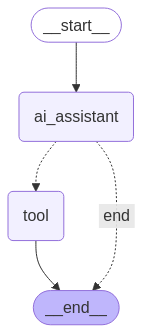

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
for s in app.stream({"messages": ["Trump Tarif imposition on countries?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ve1d', 'function': {'arguments': '{"query":"Trump Tariff imposition on countries"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 1074, 'total_tokens': 1158, 'completion_time': 0.152727273, 'prompt_time': 0.037802899, 'queue_time': 0.235088476, 'total_time': 0.190530172}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ec044012-1d97-4bde-93b4-ea4c60406e40-0', tool_calls=[{'name': 'search', 'args': {'query': 'Trump Tariff imposition on countries'}, 'id': 'call_ve1d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1074, 'output_tokens': 84, 'total_tokens': 1158})]}
----
Selected tool: search
{'messages': [[{'url': 'https://taxfoundation.org/research/all/federal/trump-tariffs-trade-war/', 'content': 'President Trump has threatened to impose Internat

In [32]:
for s in app.stream({"messages": ["what is multiplication of 23 and 46?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g4tn', 'function': {'arguments': '{"first_number":23,"second_number":46}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1080, 'total_tokens': 1172, 'completion_time': 0.167272727, 'prompt_time': 0.046707628, 'queue_time': 0.23775940099999998, 'total_time': 0.213980355}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-320ca2ec-2c66-4f01-8533-46220f24471a-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 23, 'second_number': 46}, 'id': 'call_g4tn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1080, 'output_tokens': 92, 'total_tokens': 1172})]}
----
Selected tool: multiply
{'messages': [1058]}
----


In [33]:

for s in app.stream({"messages": ["How many life lodd in Myammar Earth quakes 2025?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7a75', 'function': {'arguments': '{"query":"How many life lodd in Myanmar Earth quakes 2025"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 1086, 'total_tokens': 1180, 'completion_time': 0.170909091, 'prompt_time': 0.037954998, 'queue_time': 0.235767731, 'total_time': 0.208864089}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d06f9837-22f2-4404-9b05-4fab5abdc154-0', tool_calls=[{'name': 'search', 'args': {'query': 'How many life lodd in Myanmar Earth quakes 2025'}, 'id': 'call_7a75', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1086, 'output_tokens': 94, 'total_tokens': 1180})]}
----
Selected tool: search
{'messages': [[{'url': 'https://www.britannica.com/event/Myanmar-earthquake-of-2025', 'content': 'Myanmar earthquake of 2025,  powerful m

In [34]:
## LangGraph supports human-in-the-loop workflows in a number of ways. In this section, we will use LangGraph's interrupt_before functionality to always break the tool node.

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [35]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [36]:
tavily=TavilySearchResults()

In [37]:
tools = [tavily]

In [38]:
llm_with_tools = llm.bind_tools(tools)

In [39]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [40]:
memory = MemorySaver()

In [41]:
graph_builder = StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [42]:
graph_builder.add_edge(START, "ai_assistant")

graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [43]:
app2 = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

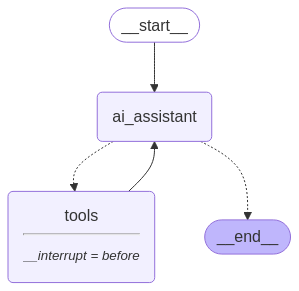

In [44]:
# from IPython.display import Image, display
# display(Image(app2.get_graph().draw_mermaid_png()))

from IPython.display import display, Image

try:
    img_data = app2.get_graph().draw_mermaid_png()
    display(Image(data=img_data))
except Exception as e:
    print(f"Failed to render diagram: {e}")

In [45]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [46]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [47]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is current a capital of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_nxj6)
 Call ID: call_nxj6
  Args:
    query: What is the capital of India?


In [48]:
snapshot = app2.get_state(config)

In [49]:
snapshot.next

('tools',)

In [50]:
last_message=snapshot.values["messages"][-1]

In [51]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'What is the capital of India?'},
  'id': 'call_nxj6',
  'type': 'tool_call'}]

In [52]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [53]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_nxj6)
 Call ID: call_nxj6
  Args:
    query: What is the capital of India?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.usatoday.com/story/news/world/2023/05/24/what-is-the-capital-of-india/70195720007/", "content": "Want to learn more about the soon-to-be most populous country? Here’s some interesting information about how India is organized.\n\nWhat is the capital of India?\n\nThe capital of India is New Delhi, located in the north-central part of the country to the west of the Yamuna River.\n\nCalcutta (now Kolkata, the capital of West Bengal) was the country’s capital until 1911 when King George V declared Delhi the new capital and construction of New Delhi began. [...] When the national government achieved independence in 1947, New Delhi became the capital.\n\nMumb

In [54]:
user_input = "what is a weather there?"

config = {"configurable": {"thread_id": "1"}}

In [55]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [56]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather there?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ggrx)
 Call ID: call_ggrx
  Args:
    query: weather in New Delhi


In [57]:
snapshot = app2.get_state(config)

In [58]:
snapshot.next

('tools',)

In [59]:
last_message=snapshot.values["messages"][-1]

In [60]:
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in New Delhi'},
  'id': 'call_ggrx',
  'type': 'tool_call'}]

In [61]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = app2.stream(None, config, stream_mode="values")

In [62]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ggrx)
 Call ID: call_ggrx
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://timesofindia.indiatimes.com/weather/new-delhi-weather-forecast-today/110011", "content": "Today's Weather in New Delhi: In New Delhi today, the weather is expected to be Haze with a maximum temperature of 39°C and a minimum of 28°C. Sunrise in"}, {"url": "https://en.climate-data.org/asia/india/delhi/new-delhi-30/t/april-4/", "content": "17. April | 29 °C | 84 °F | 36 °C | 97 °F | 21 °C | 70 °F | 1.6 mm | 0.1 inch.\n18. April | 29 °C | 85 °F | 36 °C | 97 °F | 22 °C | 71 °F | 2.0 mm | 0.1 inch.\n19. April | 30 °C | 85 °F | 37 °C | 99 °F | 22 °C | 71 °F | 2.4 mm | 0.1 inch.\n20. April | 30 °C | 86 °F | 38 °C | 100 °F | 22 °C | 71 °F | 2.2 mm | 0.1 inch.\n21. April | 3

In [63]:
app2.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='what is current a capital of india?', additional_kwargs={}, response_metadata={}, id='44889c8d-45ed-4571-8f51-5a1335f4bf46'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nxj6', 'function': {'arguments': '{"query":"What is the capital of India?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 989, 'total_tokens': 1081, 'completion_time': 0.167272727, 'prompt_time': 0.042849312, 'queue_time': 0.250335956, 'total_time': 0.210122039}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4f62f1ab-e43e-4a08-9dc3-3c52a26c2331-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'What is the capital of India?'}, 'id': 'call_nxj6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 989, 'output_tokens': 92, 'total_tokens': 10

In [64]:
snapshot=app2.get_state(config)

In [65]:
snapshot.next

('tools',)

In [66]:
user_input = "give me the recent news of it?"

config = {"configurable": {"thread_id": "1"}}

In [67]:
# The config is the **second positional argument** to stream() or invoke()!
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [68]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the recent news of it?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_webg)
 Call ID: call_webg
  Args:
    query: Recent news of New Delhi


In [69]:
snapshot=app2.get_state(config)

In [70]:
current_message = snapshot.values["messages"][-1]

In [71]:
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_webg)
 Call ID: call_webg
  Args:
    query: Recent news of New Delhi


In [72]:
tool_call_id = current_message.tool_calls[0]["id"] 

In [73]:
tool_call_id

'call_webg'

In [74]:
from langchain_core.messages import AIMessage, ToolMessage

In [75]:
answer = "it is just related to raining which is happing on daily basis"

In [76]:
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [77]:
app2.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f01ba5f-536d-6697-800c-ecead6fd97d9'}}

In [78]:
print(app2.get_state(config).values["messages"][-1:])

[AIMessage(content='it is just related to raining which is happing on daily basis', additional_kwargs={}, response_metadata={}, id='485f9679-985b-45bd-9589-6d7d6590c816')]
